In [3]:
library(WGCNA)
library(readxl)
library(tidyverse)

In [4]:
matrix = read_excel('mRNA_filterde.xlsx')
matrix%>%filter(TPM_N1+TPM_N2+TPM_N3+TPM_S1+TPM_S2+TPM_S3>0)->matrix

In [5]:
aggregate(matrix%>%select(TPM_N1,TPM_N2,TPM_N3,TPM_S1,TPM_S2,TPM_S3),
          by = list(gene_name = matrix$gene_name),
          FUN = sum,
          simplify = TRUE)->matrix_agg
#write.table(matrix_agg,'mRNA_tpm.agg.csv',sep = ',',quote = FALSE,row.names = FALSE)

In [6]:
rownames(matrix_agg) <- matrix_agg$gene_name
matrix_agg <- matrix_agg%>%select(-gene_name)
mtx_log = log2(matrix_agg+1)

In [7]:
obs_df = data.frame(row.names = c(colnames(mtx_log)),S = c(0,0,0,1,1,1),N = c(1,1,1,0,0,0))

In [10]:
#degs
degs_mrna = read.table('mRNA.sigDEGs.csv',sep = ',',header = TRUE)
dim(degs_mrna)

[1] 3167   24

In [11]:
mtx_log_flt = mtx_log[intersect(rownames(mtx_log),degs_mrna$gene_name),]
dataExpr <- as.data.frame(t(mtx_log_flt))

In [13]:
gsg = goodSamplesGenes(dataExpr, verbose = 3)
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)

dim(dataExpr)

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 2 genes from the calculation due to too many missing samples or zero variance.
  ..step 2
Removing genes: Dcun1d2,Smarcc1


[1]    6 2475

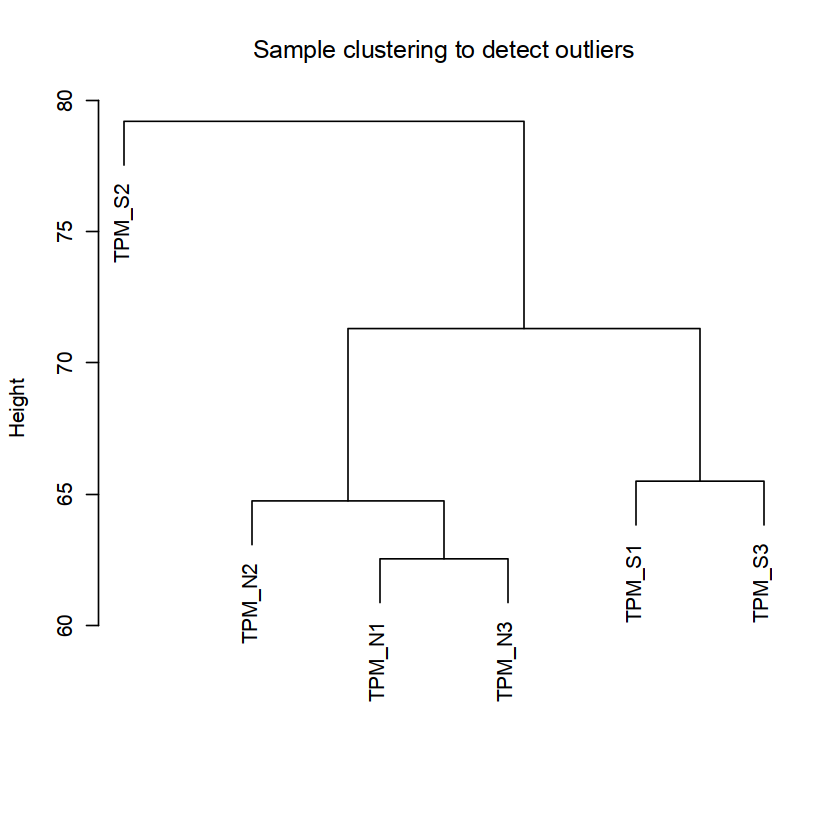

In [14]:
## 查看是否有离群样品
sampleTree = hclust(dist(dataExpr), method = "average")
#pdf('result/sampleTree.pdf')
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")
#dev.off()

pickSoftThreshold: will use block size 2475.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2475 of 2475
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.00634 -0.515          0.614   970.0     950.0 1200.0
2      2  0.29500 -1.840          0.516   532.0     509.0  747.0
3      3  0.34200 -1.520          0.550   341.0     319.0  530.0
4      4  0.43000 -1.360          0.610   240.0     221.0  406.0
5      5  0.54100 -1.460          0.731   180.0     166.0  333.0
6      6  0.60500 -1.520          0.769   142.0     132.0  283.0
7      7  0.67400 -1.610          0.787   115.0     107.0  246.0
8      8  0.73600 -1.710          0.803    95.7      88.5  219.0
9      9  0.78400 -1.820          0.829    81.3      75.7  199.0
10    10  0.80500 -1.890          0.828    70.3      64.8  183.0
11    12  0.80600 -1.910          0.801    54.7      49.5  159.0
12    14  0.81000 -1.880          0.797    44.2      38.6  141.0


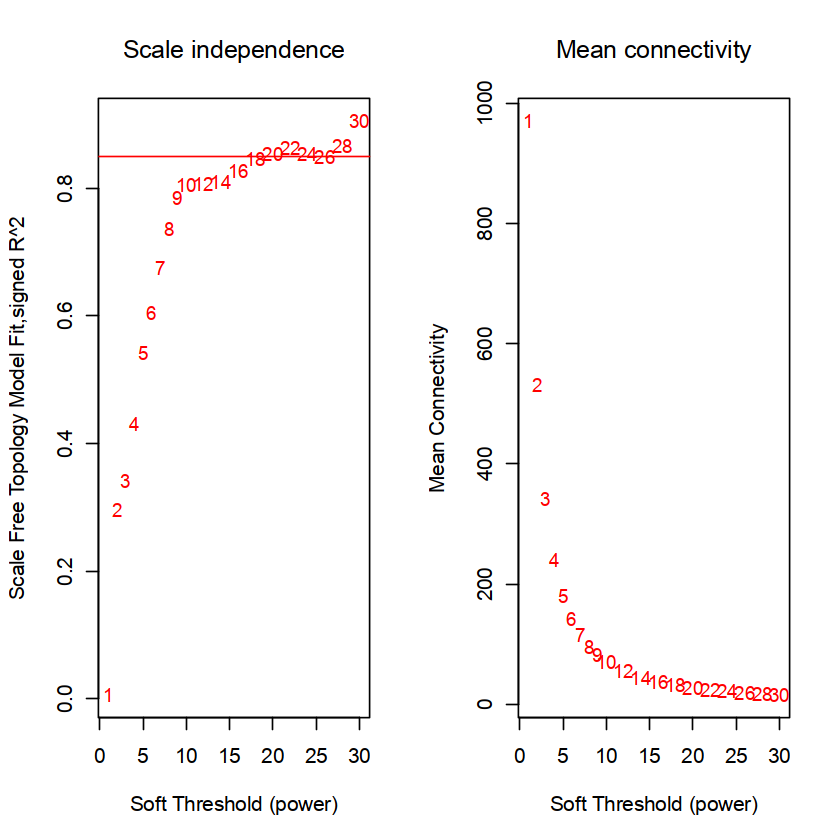

In [26]:
type = "unsigned" 
corType = "pearson"
corFnc = ifelse(corType=="pearson", 'cor', 'bicor')
maxPOutliers = ifelse(corType=="pearson",1,0.05)
robustY = ifelse(corType=="pearson",T,F)
exprMat <- "result/wgcna"

powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

par(mfrow = c(1,2))
cex1 = 0.9
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
#pdf(paste0(exprMat,'.Scale_independence.pdf'))
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.85,col="red")
#dev.off()

# Soft threshold与平均连通性
#pdf(paste0(exprMat,'.Mean_connectivity.pdf'))
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")
#dev.off()

In [27]:
power = sft$powerEstimate
power
# 无向网络在power小于15或有向网络power小于30内，没有一个power值可以使
# 无标度网络图谱结构R^2达到0.8，平均连接度较高如在100以上，可能是由于
# 部分样品与其他样品差别太大。这可能由批次效应、样品异质性或实验条件对
# 表达影响太大等造成。可以通过绘制样品聚类查看分组信息和有无异常样品。
# 如果这确实是由有意义的生物变化引起的，也可以使用下面的经验power值。
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}
power

[1] 20

[1] 20

In [28]:
net = blockwiseModules(dataExpr, power = power, maxBlockSize = nGenes,
                       TOMType = type, minModuleSize = 30,
                       reassignThreshold = 0, mergeCutHeight = 0.25,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs=TRUE, corType = corType, 
                       maxPOutliers=maxPOutliers, loadTOMs=TRUE,
                       saveTOMFileBase = paste0(exprMat, ".tom"),
                       verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file result/wgcna.tom-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
 ..merging modules that are too close..
     mergeCloseModules: Merging modules whose distance is less than 0.25
       Calculating new MEs...


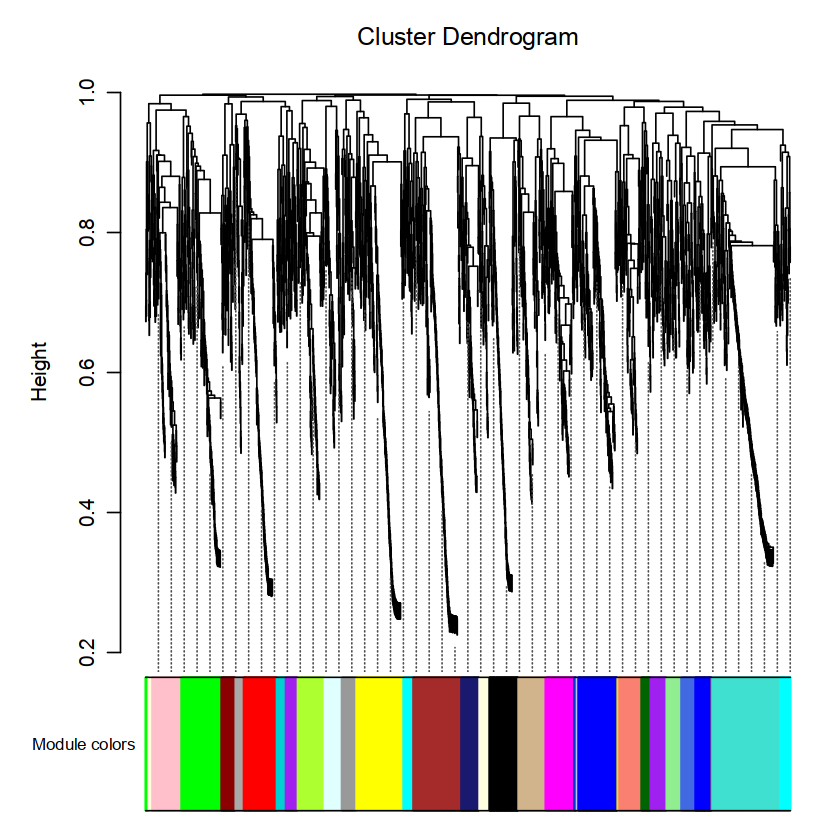

In [30]:
moduleLabels = net$colors
moduleColors = labels2colors(moduleLabels)
#pdf(paste0(exprMat,'.ME_dendrogram.pdf'))
plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)
#dev.off()

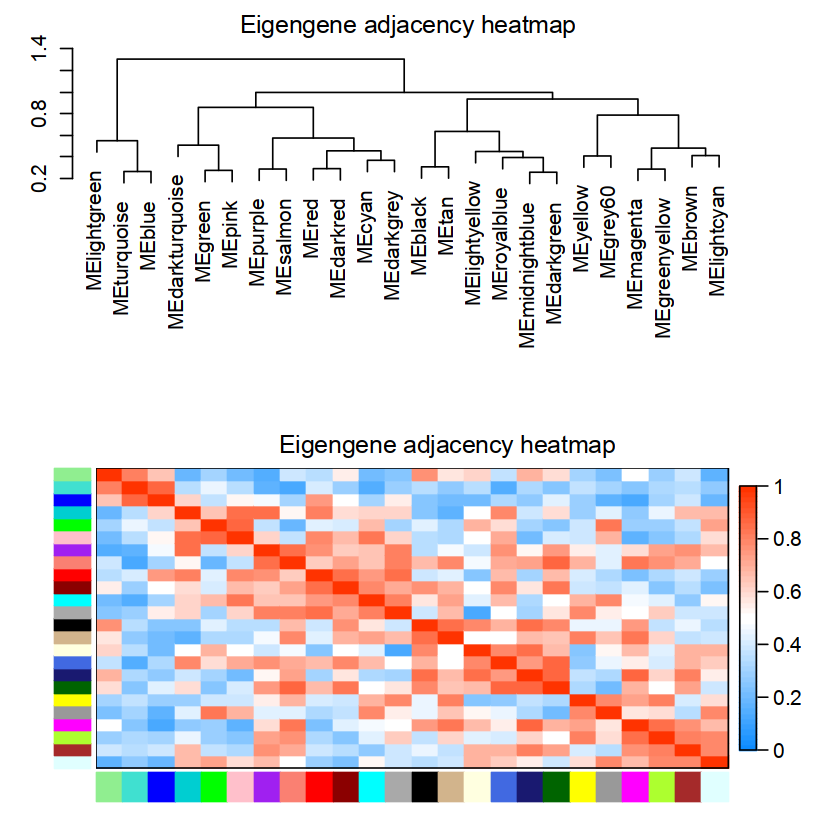

In [32]:
# module eigengene, 可以绘制线图，作为每个模块的基因表达趋势的展示
MEs = net$MEs

### 不需要重新计算，改下列名字就好
### 官方教程是重新计算的，起始可以不用这么麻烦
MEs_col = MEs
colnames(MEs_col) = paste0("ME", labels2colors(
  as.numeric(str_replace_all(colnames(MEs),"ME",""))))
MEs_col = orderMEs(MEs_col)

# 根据基因间表达量进行聚类所得到的各模块间的相关性图
# marDendro/marHeatmap 设置下、左、上、右的边距
#pdf(paste0(exprMat,'.Eigengene_adjacent_heatmap.pdf'),height = 9)
plotEigengeneNetworks(MEs_col, "Eigengene adjacency heatmap", 
                      marDendro = c(3,3,2,4),
                      marHeatmap = c(3,4,2,2), plotDendrograms = T, 
                      xLabelsAngle = 90)
#dev.off()

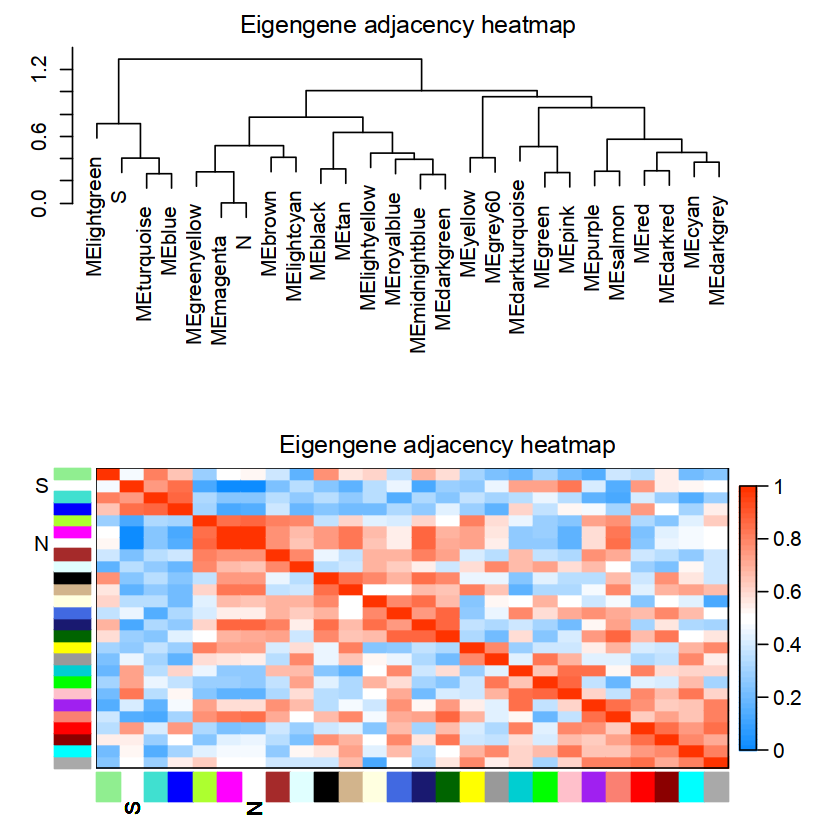

In [34]:
## 如果有表型数据，也可以跟ME数据放一起，一起出图
MEs_colpheno = orderMEs(cbind(MEs_col, obs_df))
#pdf(paste0(exprMat,'.sample.Eigengene_adjacent_heatmap.pdf'),height = 10)
plotEigengeneNetworks(MEs_colpheno, "Eigengene adjacency heatmap", 
                      marDendro = c(3,3,2,4),
                      marHeatmap = c(3,4,2,2), plotDendrograms = T, 
                      xLabelsAngle = 90)
#dev.off()

In [45]:
#基因数很多，非常耗时

# 如果采用分步计算，或设置的blocksize>=总基因数，直接load计算好的TOM结果
# 否则需要再计算一遍，比较耗费时间
# TOM = TOMsimilarityFromExpr(dataExpr, power=power, corType=corType, networkType=type)
load(net$TOMFiles[1], verbose=T)

## Loading objects:
##   TOM

TOM <- as.matrix(TOM)

dissTOM = 1-TOM
# Transform dissTOM with a power to make moderately strong 
# connections more visible in the heatmap
plotTOM = dissTOM^7
# Set diagonal to NA for a nicer plot
diag(plotTOM) = NA
# Call the plot function

# 这一部分特别耗时，行列同时做层级聚类
#pdf(paste0(exprMat,'.network_heatmap.pdf'),width=7)
TOMplot(plotTOM, net$dendrograms, moduleColors, 
        main = "Network heatmap plot, all genes")
#dev.off()

Loading objects:
  TOM


Warning message in min(dendro$height):
“no non-missing arguments to min; returning Inf”
Warning message in max(dendro$height):
“no non-missing arguments to max; returning -Inf”
Warning message in min(dendro$height):
“no non-missing arguments to min; returning Inf”


png 
  2

In [37]:
probes = colnames(dataExpr)
dimnames(TOM) <- list(probes, probes)

# Export the network into edge and node list files Cytoscape can read
# threshold 默认为0.5, 可以根据自己的需要调整，也可以都导出后在
# cytoscape中再调整
cyt = exportNetworkToCytoscape(TOM,
             edgeFile = paste(exprMat, ".edges.txt", sep=""),
             nodeFile = paste(exprMat, ".nodes.txt", sep=""),
             weighted = TRUE, threshold = 0,
             nodeNames = probes, nodeAttr = moduleColors)

In [110]:
#edge_df = read.table('result/WGCNA.Clean.txt.edges.txt',header = TRUE)

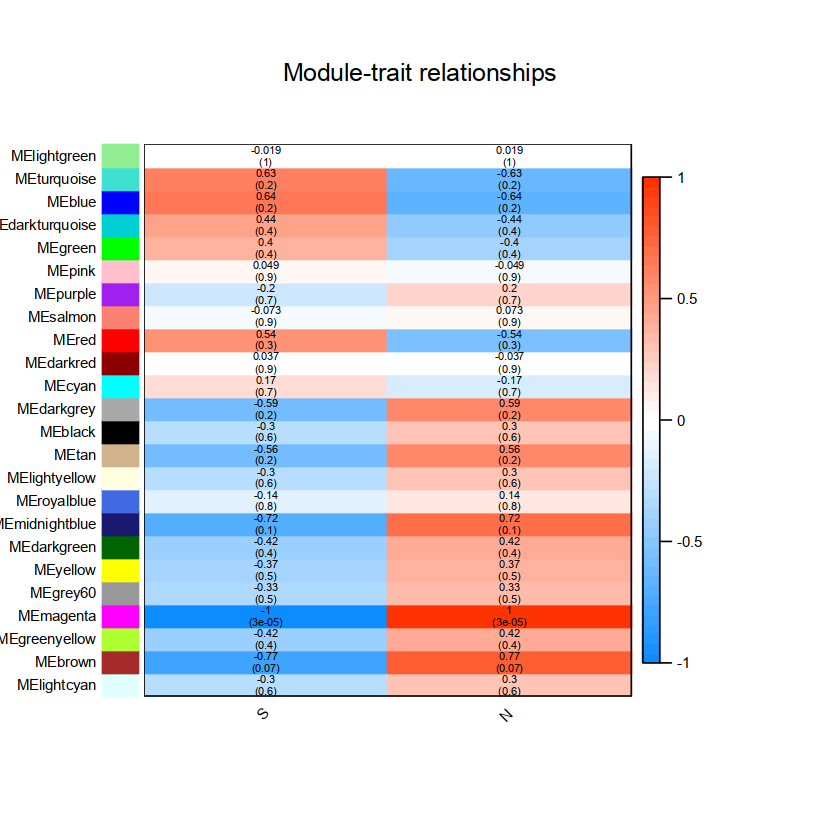

In [141]:
#trait <- "WGCNA/TraitsClean"
# 读入表型数据，不是必须的
#if(trait != "") {
#  traitData <- read.table(file=trait, sep='\t', header=T, row.names=1,
#                          check.names=FALSE, comment='',quote="")
#  sampleName = rownames(dataExpr)
#  traitData = traitData[match(sampleName, rownames(traitData)), ]
#}

traitData = obs_df

### 模块与表型数据关联
if (corType=="pearsoon") {
  modTraitCor = cor(MEs_col, traitData, use = "p")
  modTraitP = corPvalueStudent(modTraitCor, nSamples)
} else {
  modTraitCorP = bicorAndPvalue(MEs_col, traitData, robustY=robustY)
  modTraitCor = modTraitCorP$bicor
  modTraitP   = modTraitCorP$p
}

## Warning in bicor(x, y, use = use, ...): bicor: zero MAD in variable 'y'.
## Pearson correlation was used for individual columns with zero (or missing)
## MAD.

# signif表示保留几位小数
textMatrix = paste(signif(modTraitCor, 2), "\n(", signif(modTraitP, 1), ")", sep = "")
dim(textMatrix) = dim(modTraitCor)
#pdf(paste0(exprMat,'.ME_sample.pdf'),,width=5,height=8)
par(mar=c(0,0,0,0)+6)
labeledHeatmap(Matrix = modTraitCor, xLabels = colnames(traitData), 
               yLabels = colnames(MEs_col), 
               cex.lab = 0.7, 
               ySymbols = colnames(MEs_col), colorLabels = FALSE, 
               colors = blueWhiteRed(50), 
               textMatrix = textMatrix, setStdMargins = FALSE, 
               cex.text = 0.5, zlim = c(-1,1),
               main = paste("Module-trait relationships"))
#dev.off()

In [40]:
#corType="bioc"
if (corType=="pearsoon") {
  geneModuleMembership = as.data.frame(cor(dataExpr, MEs_col, use = "p"))
  MMPvalue = as.data.frame(corPvalueStudent(
             as.matrix(geneModuleMembership), nSamples))
} else {
  geneModuleMembershipA = bicorAndPvalue(dataExpr, MEs_col, robustY=robustY)
  geneModuleMembership = geneModuleMembershipA$bicor
  MMPvalue   = geneModuleMembershipA$p
}

if (corType=="pearsoon") {
  geneTraitCor = as.data.frame(cor(dataExpr, traitData, use = "p"))
  geneTraitP = as.data.frame(corPvalueStudent(
             as.matrix(geneTraitCor), nSamples))
} else {
  geneTraitCorA = bicorAndPvalue(dataExpr, traitData, robustY=robustY)
  geneTraitCor = as.data.frame(geneTraitCorA$bicor)
  geneTraitP   = as.data.frame(geneTraitCorA$p)
}

Warning message in bicor(x, y, use = use, ...):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(x, y, use = use, ...):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


In [42]:
for(module in str_replace_all(colnames(MEs_col),'ME','')){
    for(pheno in c('S','N')){
        modNames = substring(colnames(MEs_col), 3)
        # 获取关注的列
        module_column = match(module, modNames)
        pheno_column = match(pheno,colnames(traitData))

        moduleGenes = moduleColors == module
        pdf(paste0('result/Scatterplot/',module,'_',pheno,'.pdf'))
        verboseScatterplot(abs(geneModuleMembership[moduleGenes, module_column]),
                           abs(geneTraitCor[moduleGenes, pheno_column]),
                           xlab = paste("Module Membership in", module, "module"),
                           ylab = paste("Gene significance for", pheno),
                           main = paste("Module membership vs. gene significance\n"),
                           cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
        dev.off()
    }
}

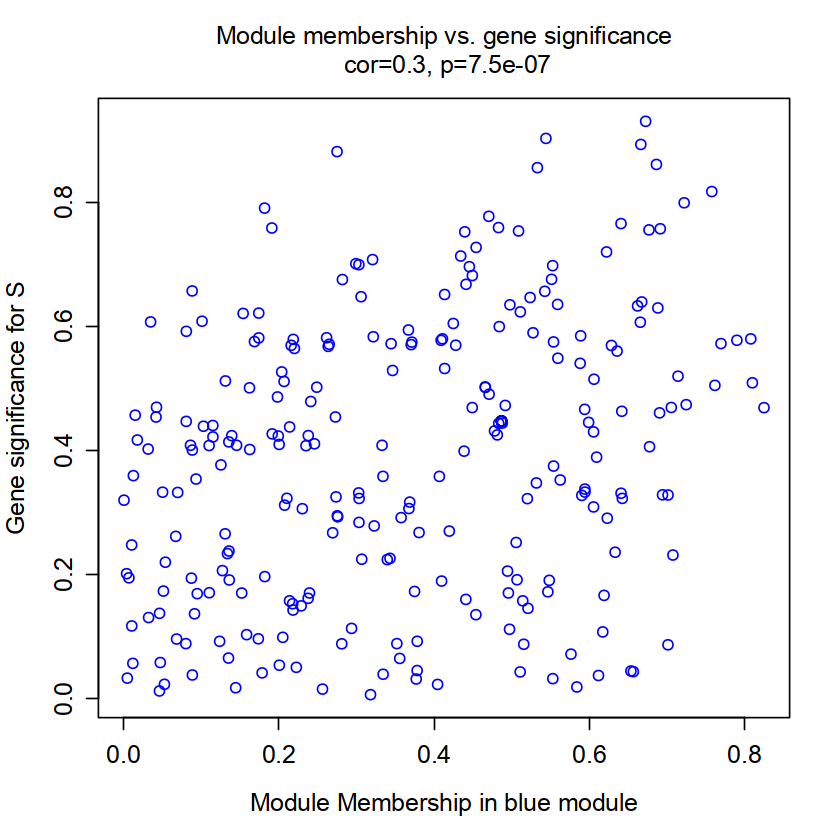

In [105]:
verboseScatterplot(abs(geneModuleMembership[moduleGenes, module_column]),
                   abs(geneTraitCor[moduleGenes, pheno_column]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = paste("Gene significance for", pheno),
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)

In [48]:
#hub gene
ADJ=abs(cor(dataExpr,use="p"))^6
Alldegrees =intramodularConnectivity(ADJ, moduleColors)
write.csv(Alldegrees, file = "result/Hubgene/intramodularConnectivity.csv")

In [53]:
nSamples = nrow(dataExpr)
# 指定datTrait中感兴趣的一个性状
group = as.data.frame(obs_df$S)
names(group) = "Group"
modNames = substring(names(MEs), 3)
# 计算MM的P值
geneModuleMembership = as.data.frame(cor(dataExpr, MEs, use = "p"))
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))
 names(geneModuleMembership) = paste("MM", modNames, sep="")
 names(MMPvalue) = paste("p.MM", modNames, sep="")
# 计算性状和基因表达量之间的相关性（GS）
 geneTraitSignificance = as.data.frame(cor(dataExpr, group, use = "p"))
 GSPvalue = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))
 names(geneTraitSignificance) = paste("GS.", names(group), sep="")
 names(GSPvalue) = paste("p.GS.", names(group), sep="")

In [88]:
for(module in str_replace_all(colnames(MEs_col),'ME','')){
    for(pheno in c('S','N')){
        modNames = substring(colnames(MEs_col), 3)
        # 获取关注的列
        module_column = match(module, modNames)
        pheno_column = match(pheno,colnames(traitData))

        moduleGenes = moduleColors == module
        
        df = data.frame(MM = geneModuleMembership[moduleGenes, module_column],
                   GS = geneTraitCor[moduleGenes, pheno_column],
                   module = module,
                   pheno = pheno,
                    gene = rownames(geneModuleMembership[moduleGenes,])
                  )
        write.table(df,paste0('result/Scatterplot/',module,'_',pheno,'.csv'),sep = ',',quote = FALSE,row.names = FALSE)
        
         df = data.frame(MM = abs(geneModuleMembership[moduleGenes, module_column]),
                   GS = abs(geneTraitCor[moduleGenes, pheno_column]),
                   module = module,
                   pheno = pheno,
                    gene = rownames(geneModuleMembership[moduleGenes,])
                  )
        write.table(df,paste0('result/Scatterplot/',module,'_',pheno,'.abs.csv'),sep = ',',quote = FALSE,row.names = FALSE)
        }
                        
}

In [100]:
#KME

# 计算KME值
datKME=signedKME(dataExpr, MEs_col, outputColumnName="kME_MM.")
datKME$gene = rownames(datKME)
write.table(datKME, "result/Hubgene/kME_MM.csv",sep = ',',quote = FALSE,row.names = FALSE)

In [105]:
for(module in str_replace_all(colnames(MEs_col),'ME','')){
    FilterGenes = abs(datKME[,paste0('kME_MM.',module)]) > 0.8
    hubgene <- dimnames(data.frame(dataExpr))[[2]][FilterGenes]
    write.csv(hubgene, paste0("result/Hubgene/hubgene_KME_",module,".csv"),sep = ',',quote =FALSE,row.names = FALSE)
}

Warning message in write.csv(hubgene, paste0("result/Hubgene/hubgene_KME_", module, :
“attempt to set 'sep' ignored”
Warning message in write.csv(hubgene, paste0("result/Hubgene/hubgene_KME_", module, :
“attempt to set 'sep' ignored”
Warning message in write.csv(hubgene, paste0("result/Hubgene/hubgene_KME_", module, :
“attempt to set 'sep' ignored”
Warning message in write.csv(hubgene, paste0("result/Hubgene/hubgene_KME_", module, :
“attempt to set 'sep' ignored”
Warning message in write.csv(hubgene, paste0("result/Hubgene/hubgene_KME_", module, :
“attempt to set 'sep' ignored”
Warning message in write.csv(hubgene, paste0("result/Hubgene/hubgene_KME_", module, :
“attempt to set 'sep' ignored”
Warning message in write.csv(hubgene, paste0("result/Hubgene/hubgene_KME_", module, :
“attempt to set 'sep' ignored”
Warning message in write.csv(hubgene, paste0("result/Hubgene/hubgene_KME_", module, :
“attempt to set 'sep' ignored”
Warning message in write.csv(hubgene, paste0("result/Hubgene/hub

In [107]:
 HubGenes <- chooseTopHubInEachModule(dataExpr,moduleColors)
write.csv (HubGenes,file = "result/Hubgene/TopHubGenes_of_each_module.csv",quote=F)

In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /Personal/fuxin/.conda/envs/r_4.1/lib/libopenblasp-r0.3.23.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] forcats_0.5.1         stringr_1.4.0         dplyr_1.1.4.9000     
 [4] purrr_0.3.4           readr_1.4.0           tidyr_1.1.3          
 [7] tibble_3.2.1          ggplot2_3.3.5         tidyverse_1.3.1      
[10] readxl_1.3.1          WGCNA_1.71            fastcluster_1.2.3    
[13] dynamicTreeCut